In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('bank.csv', sep=";")

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
df.shape

(4521, 17)

##  Understanding Data

Model learns patterns from data. If we don't understand the data, we won't be able to understand the model.


In [7]:
# Target Variable

df['y'].value_counts()

y
no     4000
yes     521
Name: count, dtype: int64

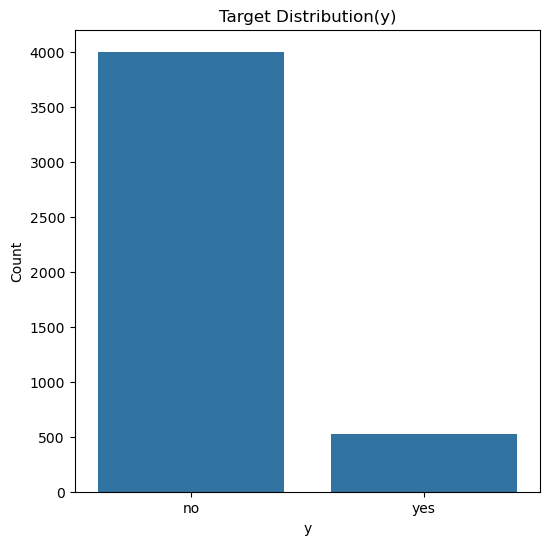

In [10]:
# Visualise target variable

plt.figure(figsize=(6,6))
sns.countplot(x='y',data=df)
plt.title("Target Distribution(y)")
plt.ylabel('Count')
plt.show()

1. Mostly customers say NO.
2. Very few said YES.
3. This is called **class imbalance**.
4. This will matter later when we evaluate models.

In [11]:
# Numeric Columns

num_cols = df.select_dtypes(include='int64').columns

In [ ]:
num_cols

# These are numeric columns. We can plot them to understand spread and scale.

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

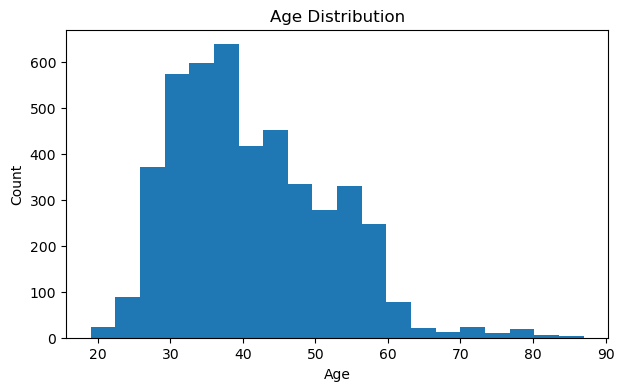

In [13]:
# Age Distribution


plt.figure(figsize=(7,4))
plt.hist(df['age'], bins=20)
plt.title("Age Distribution")
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

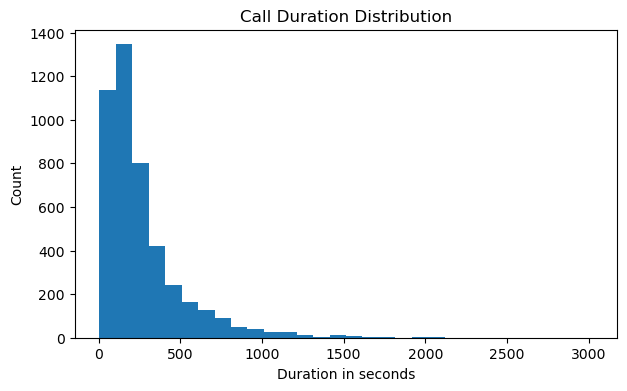

In [14]:
plt.figure(figsize=(7,4))
plt.hist(df['duration'],bins=30)
plt.title('Call Duration Distribution')
plt.xlabel('Duration in seconds')
plt.ylabel('Count')
plt.show()

1. Features are skewed.
2. Some have very large ranges.
3. Therefore **scaling is needed**.

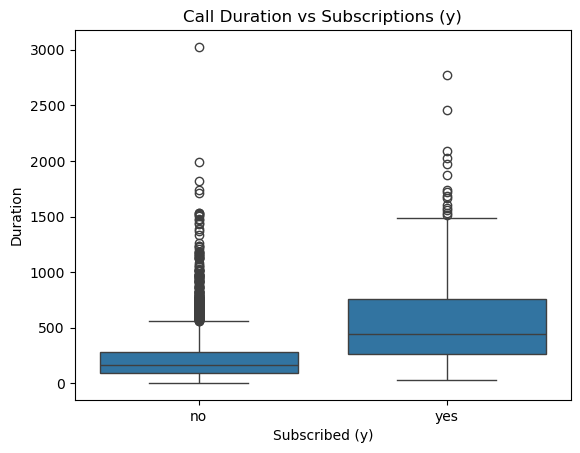

In [16]:
# Duration vs y(target)

sns.boxplot(x='y', y='duration', data=df)
plt.title('Call Duration vs Subscriptions (y)')
plt.xlabel('Subscribed (y)')
plt.ylabel('Duration')
plt.show()

Customers who say **YES** generally have longer call durations.

# Classification

## 1. Seperate X *(features)* and y *(target)*.

In [18]:
X = df.drop('y',axis=1)
y = df['y']

In [19]:
X.shape

(4521, 16)

In [20]:
y.shape

(4521,)

## 2. Numeric and Category col

In [21]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include='int64').columns

1. Category : **encoding**
2. Numeric : **scaling**

## 3. Encoding

In [22]:
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [26]:
print("Before encoding:",X.shape)

Before encoding: (4521, 16)


In [29]:
print("After encoding:",X_encoded.shape)

# After encoding, everything becomes numeric (0/1 columns are created).

After encoding: (4521, 42)


## 4. Train Test Split

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [33]:
print(X_train.shape, X_test.shape)

(3616, 42) (905, 42)


## 5. Scaling

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()

In [38]:
# making copies so that we don't mess up original dataframe.

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [40]:
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols]) # Fit on train numeric col only

In [ ]:
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols]) # Transdorm test numeric col only (NO fit here)

1. Train data decides scaling rules.
2. Test data only follows those rules.
3. **No data leakage** : The model accidentally gets access to information from the testing while it is still learning. 

## 6. Train Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
model = LogisticRegression(max_iter=500)
model.fit(X_train_scaled,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


## 7. Prediction

In [45]:
y_pred = model.predict(X_test_scaled)

## 8. Evaluation

**Accuracy + Confusion Matrix + Classification Report**

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

In [47]:
acc = accuracy_score(y_test, y_pred)
print("accuracy",acc)

accuracy 0.8928176795580111


In [51]:
cm = confusion_matrix(y_test, y_pred, labels=['no','yes'])
cm

array([[777,  24],
       [ 73,  31]])

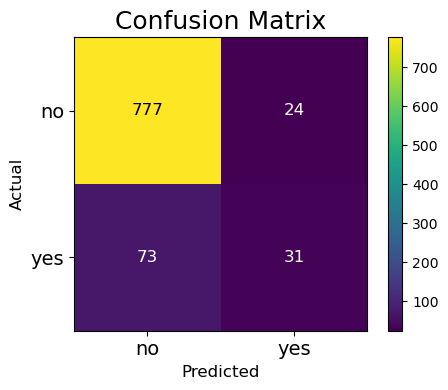

In [69]:
plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)

plt.xticks([0,1], ['no', 'yes'], fontsize=14)
plt.yticks([0,1],['no','yes'],fontsize=14)


for i in range(2):
    for j in range(2):
        val = cm[i,j]
        if val > cm.max()/2:
            color = 'black'
        else:
            color = 'white'
        plt.text(j,i,val, ha='center',va='center',fontsize=12,color=color)


plt.colorbar()
plt.tight_layout()

ROWS = **Actual**
Columns = **Predicted**

1. TOP LEFT = **correct NO**
2. BOTTOM RIGHT = **correct YES**
3. BOTTOM LEFT = **missed YES**
4. TOP RIGHT = **false YES**

In [71]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.91      0.97      0.94       801
         yes       0.56      0.30      0.39       104

    accuracy                           0.89       905
   macro avg       0.74      0.63      0.67       905
weighted avg       0.87      0.89      0.88       905



# Improving **'YES'** Class Performance

From confusion matrix

- False Negative = 70
- True Positive = 30

Our model is missing many customers who would actually subscribe. So we want our model to identify more **YES** customers.

In [75]:
y_prob = model.predict_proba(X_test_scaled)
y_prob[:5]


# Col 0 : Probablity of NO
# Col 1 : Probabloty of YES

array([[0.81544881, 0.18455119],
       [0.97371278, 0.02628722],
       [0.97384245, 0.02615755],
       [0.98856985, 0.01143015],
       [0.97938451, 0.02061549]])

In [ ]:
y_yes_prob = y_prob[:,1]

# This col tells us how confident the model is that the customer will say YES.

In [76]:
y_pred_default = model.predict(X_test_scaled)

In [78]:
threshold = 0.3

y_pred_30 = []
for p in y_yes_prob:
    if p >= threshold:
        y_pred_30.append("yes")
    else:
        y_pred_30.append("no")

In [81]:
cm_30 = confusion_matrix(y_test, y_pred_30, labels=['no','yes'])
print(cm_30)

[[747  54]
 [ 54  50]]


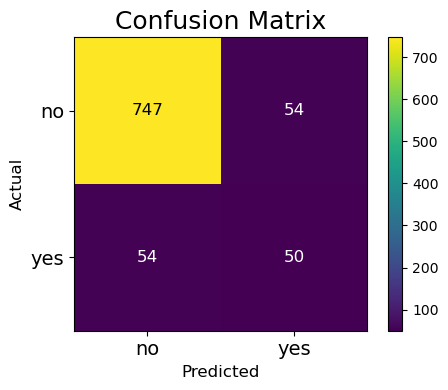

In [82]:
plt.figure(figsize=(5,4))
plt.imshow(cm_30)
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)

plt.xticks([0,1], ['no', 'yes'], fontsize=14)
plt.yticks([0,1],['no','yes'],fontsize=14)


for i in range(2):
    for j in range(2):
        val = cm_30[i,j]
        if val > cm_30.max()/2:
            color = 'black'
        else:
            color = 'white'
        plt.text(j,i,val, ha='center',va='center',fontsize=12,color=color)


plt.colorbar()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_30))

              precision    recall  f1-score   support

          no       0.93      0.93      0.93       801
         yes       0.48      0.48      0.48       104

    accuracy                           0.88       905
   macro avg       0.71      0.71      0.71       905
weighted avg       0.88      0.88      0.88       905

